In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pyBedGraph import BedGraph
from pybedtools import BedTool
import scipy.stats
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm
from collections import Counter

In [11]:
#### Define functions ####
def modLog(num, denom):
    if num==0 or denom==0:
        return 0
    else:
        return float(format(np.log2(num/denom), '.4f'))

def ShannonEnt(probList):
    """Compute entropy for a list of probabilities."""
    if sum(probList)!=1:  ## input is count or frequency instead of probability
        probList = [i/sum(probList) for i in probList]
    entropy = sum([x*modLog(1,x) for x in probList])
    return float(format(entropy, '.6f'))

def normShannonEnt(probList):
    """Compute normalized entropy for a list of probabilities."""
    if sum(probList) != 1:   ## input is count or frequency instead of probability
        probList = [i/sum(probList) for i in probList]
    entropy = sum([x*modLog(1,x) for x in probList])/np.log2(len(probList))
    if len(probList) == 1:
        entropy = 0
    return float(format(entropy, '.6f'))

def KLdiv(p, q):
    """Compute KL divergence for two distributions p and q."""
    if sum(p)!=1:
        p = [i/sum(p) for i in p]
    if sum(q)!=1:
        q = [i/sum(q) for i in q]
    div = 0
    for i in range(0,len(p)):
        div = div + p[i]*modLog(p[i], q[i])
    return float(format(div, '.6f'))

def JSdiv(p, q):
    """Compute KL divergence for two distributions p and q."""
    if sum(p)!=1:
        p = [i/sum(p) for i in p]
    if sum(q)!=1:
        q = [i/sum(q) for i in q]
    m = [(p[i]+q[i])/2 for i in range(len(p))]
    div = KLdiv(p, m)/2 + KLdiv(q, m)/2
    return float(format(div, '.6f'))

In [12]:
def read_cf(directory, file_name):
    with open(directory + file_name) as f:
        chrom = {}
        for line in f:
            tmp = line.strip().split("\t")
            if tmp[0] != 'chrM':
                chrom[tmp[0]] = int(tmp[1])
    return chrom

In [13]:
def read_allresult(directory, file_name):
    with open(directory + file_name) as f:
        alllist = []
        for line in f:
            tmp = line.strip().split("\t")
            if tmp[0] != 'LoopID':
                alllist.append([tmp[0], int(tmp[3]), int(tmp[7]), int(tmp[11]), tmp[22], tmp[23]])
    return alllist

In [14]:
def read_crnresult(directory, file_name):
    with open(directory + file_name) as f:
        crnlist = []
        next(f)
        for line in f:
            tmp = line.strip().split("\t")
            for i in range(4,9):
                tmp[i] = int(tmp[i])
            crnlist.append(tmp)
    return crnlist

In [15]:
def read_bedpe(directory, file_name):
    with open(directory + file_name) as f:
        elements = {}
        for line in f:
            tmp = line.strip().split("\t")
            elements[tmp[6]] = [tmp[0], int(tmp[1]), int(tmp[2])]
            elements[tmp[7]] = [tmp[3], int(tmp[4]), int(tmp[5])]
    return elements

In [16]:
def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

In [17]:
def plotscatter(x1,x2,  tit, xlab, ylab, fig_name):
    samples = np.array([x1, x2])
    densObj = kde( samples )
    colours = makeColours( densObj.evaluate( samples ) )
    plt.figure(figsize=(7,7))
    plt.scatter( samples[0], samples[1], color=colours , alpha = 0.5, edgecolors='none')
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    pearson = round(scipy.stats.pearsonr(x1, x2)[0], 2)
    spearman = round(scipy.stats.spearmanr(x1, x2)[0], 2)
    plt.title(tit+ "\n Pearson = " + str(pearson)+", Spearman = " + str(spearman) + ", n="+str(len(x1)), fontsize=15)
    plt.savefig(fig_name+".pdf", dpi=100)
    plt.show()

In [18]:
def write_result(directory, out_list, out_name):
    with open(directory+out_name, 'a') as file1:
        for i in range(len(out_list)):
            file1.write('\t'.join(map(str, out_list[i])) + '\n')
    file1.close()

In [19]:
directory='/Users/kimm/Desktop/GM12878_files/'
ctcfloop_allist='GM12878-CTCF-pooled_comp_FDR_0.2_PASS_motifext4kbboth_loops_AllResults.txt'
cohesinloop_allist='GM12878-cohesin-pooled_comp_FDR_0.2_PASS_motifext4kbboth_loops_AllResults.txt'
ctcfcrn_list = 'GM12878-CTCF-pooled_comp_FDR_0.2_PASS_RAID100kb_CRNregions_stat.txt'
cohesincrn_list = 'GM12878-cohesin-pooled_comp_FDR_0.2_PASS_RAID100kb_CRNregions_stat.txt'
rnapiicrn_list = 'GM12878-RNAPII-pooledv2_comp_FDR_0.2_PASS_RAID100kb_CRNregions_stat.txt'
elements_file = 'CRN-loops.G100kb.20200705.bedpe'

In [20]:
chromfile = read_cf(directory, 'hg38.chrom.sizes')

In [21]:
elements = read_bedpe(directory, elements_file)

In [22]:
ctcfloop = read_allresult(directory, ctcfloop_allist)
cohesinloop = read_allresult(directory, cohesinloop_allist)

In [23]:
len(cohesinloop)

13549

In [24]:
conv = {}
for x in ctcfloop:
    if x[4] == '+' and x[5] == '-': # convergent loop
        conv[x[0]] = [x[1]+x[2]+x[3]]

In [25]:
for x in cohesinloop:
    if x[4] == '+' and x[5] == '-': # convergent loop
        conv[x[0]].append(x[1]+x[2]+x[3])

In [26]:
len(conv)

6385

In [27]:
ctcfc = []
cohesinc = []
for k,v in conv.items():
    ctcfc.append(v[0])
    cohesinc.append(v[1])

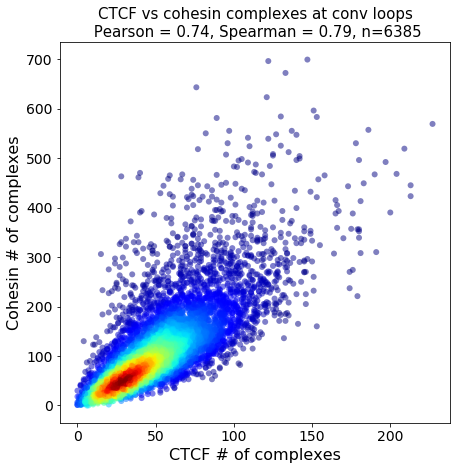

In [30]:
plotscatter(ctcfc, cohesinc, 'CTCF vs cohesin complexes at conv loops', 'CTCF # of complexes', 'Cohesin # of complexes', 'ctcf_vs_cohesin_convloops_complexes_scatterplot_20201014')